# Station Keeping example
To run this example, make sure to have installed the lateste version of the spacetower-python-sdk (1.2.0).

## Imports

In [1]:
from datetime import datetime, UTC, timedelta
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from fds.constants import EARTH_RADIUS
from fds.models.actions import ActionFiring
from fds.models.orbital_state import PropagationContext, OrbitalState
from fds.models.orbits import KeplerianOrbit, OrbitMeanOsculatingType, PositionAngleType
from fds.models.spacecraft import SpacecraftBox, ThrusterElectrical, Battery, SolarArray
from fds.models.station_keeping.requests import EphemeridesRequest, SpacecraftStatesRequest
from fds.models.station_keeping.strategy import StationKeepingStrategy
from fds.models.station_keeping.tolerance import SemiMajorAxisTolerance
from fds.models.station_keeping.use_case import LeoStationKeeping

*Note*: If you are using this notebook locally, use the following methods to configure your credentials:

```python
from fds.config import set_client_id, set_client_secret
set_client_id('CLIENT_ID')
set_client_secret('CLIENT_SECRET')
```

## Generic FDS models creation

In [2]:
mean_altitude = 500.  # mean_sma - Req [km]

orbit = KeplerianOrbit(
    semi_major_axis=EARTH_RADIUS * 1e-3 + mean_altitude,
    anomaly=0,
    argument_of_perigee=0,
    eccentricity=1e-3,
    inclination=98,
    raan=90,
    kind=OrbitMeanOsculatingType.MEAN,
    anomaly_kind=PositionAngleType.TRUE,
    date=datetime(2024, 6, 1, tzinfo=UTC)
)
propagation_context = PropagationContext(
    model_perturbations=[
        PropagationContext.Perturbation.DRAG,
        PropagationContext.Perturbation.EARTH_POTENTIAL,
    ],
    model_solar_flux=160,  # SFU
    model_earth_potential_deg=8,
    model_earth_potential_ord=8,
    model_atmosphere_kind=PropagationContext.AtmosphereModel.HARRIS_PRIESTER,
    integrator_kind=PropagationContext.IntegratorKind.DORMAND_PRINCE_853,
    integrator_min_step=0.01,  # s
    integrator_max_step=100,  # s
)
battery = Battery(
    depth_of_discharge=0.1,  # 0<x<1
    nominal_capacity=200,  # W
    minimum_charge_for_firing=0.99,  # 0<x<1
    initial_charge=1,  # 0<x<1
)

solar_array = SolarArray(
    efficiency=0.3,
    kind=SolarArray.Kind.DEPLOYABLE_FIXED,
    initialisation_kind=SolarArray.InitialisationKind.SURFACE,
    surface=0.5,
    normal_in_satellite_frame=(0.0, -1.0, 0.0),
)

electrical_thruster = ThrusterElectrical(
    isp=2500,  # s
    thrust=0.0005,  # N
    axis_in_satellite_frame=(0, 0, -1),  # Unit vector
    propellant_mass=1.0,  # kg
    wet_mass=3.0,  # kg
    warm_up_duration=0,  # s
    maximum_thrust_duration=2000,  # s
    impulse=40000.0,  # Ns
    power=50,  # W
    stand_by_power=10,  # W
    warm_up_power=0,  # W
)

spacecraft = SpacecraftBox(
    battery=battery,
    thruster=electrical_thruster,
    solar_array=solar_array,
    platform_mass=100,  # kg
    drag_coefficient=2.2,
    reflectivity_coefficient=0.5,
    length_x=.5,  # m
    length_y=.5,  # m
    length_z=.5,  # m
    max_angular_velocity=1,  # deg/s
    max_angular_acceleration=.1,  # deg/s^2
)

## Station keeping FDS models

### Strategy

In [3]:
strategy = StationKeepingStrategy(
    thrust_arcs_position=StationKeepingStrategy.ThrustArcPosition.ASCENDING_AND_DESCENDING_ANTINODES,
    thrust_arcs_number=StationKeepingStrategy.ThrustArcNumber.TWO,
    number_of_thrust_orbits=1,
    number_of_rest_orbits=1,
    number_of_shift_orbits=0,
    stop_thrust_at_eclipse=False,
    thrust_arc_initialisation_kind=StationKeepingStrategy.ThrustArcInitialisationKind.THRUST_DURATION,
    thrust_arc_duration=800,  # [s]
)

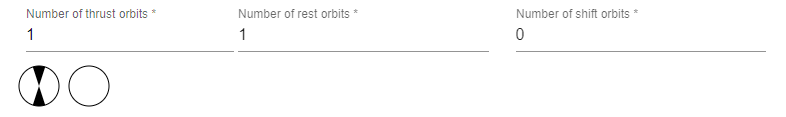

### Output ephemerides request

In [4]:

ephemerides_request = EphemeridesRequest(
    timestep=60.0,
    types=[EphemeridesRequest.EphemeridesType.KEPLERIAN, EphemeridesRequest.EphemeridesType.POWER_SYSTEM],
    mean=True,
    osculating=False
)

states_request = SpacecraftStatesRequest(mean=False, osculating=True)

### Semi-major axis tolerance

In [5]:
tolerance = SemiMajorAxisTolerance(0.4)

## Run the use case

In [6]:
sk = LeoStationKeeping(
    initial_orbit=orbit,
    propagation_context=propagation_context,
    spacecraft=spacecraft,
    maximum_duration=86400 * 45,
    tolerance=tolerance,
    output_requests=[ephemerides_request, states_request],
    strategy=strategy,
    average_available_on_board_power=50,
    simulate_attitude_and_power_system=True
)

res = sk.run().result

## Post-processing

### Functions

In [7]:
def draw_rectangles(_ax, start_dates, end_dates):
    if start_dates is None or end_dates is None or len(start_dates) == 0 or len(end_dates) == 0:
        return
    # get plot lims
    ymin, ymax = _ax.get_ylim()

    for start, end in zip(start_dates, end_dates):
        _ax.add_patch(Rectangle((start, ymin), end - start, ymax-ymin, color='red', alpha=0.2))

    # add a fake rectangle to the legend
    _ax.add_patch(Rectangle((0, 0), 0, 0, color='red', alpha=0.3, label="Firings"))

def add_grid(axis):
    axis.grid()
    axis.minorticks_on()
    axis.grid(which='major', linestyle='-', linewidth='0.5', color='black', alpha=0.5)
    axis.grid(which='minor', linestyle=':', linewidth='0.5', color='gray', alpha=0.5)


roadmap = res.generate_maneuver_roadmap()

firing_start_dates = [f.firing_start_date for f in roadmap.actions if isinstance(f, ActionFiring)]
firing_end_dates = [f.firing_end_date for f in roadmap.actions if isinstance(f, ActionFiring)]


### Plots

#### Keplerian mean elements

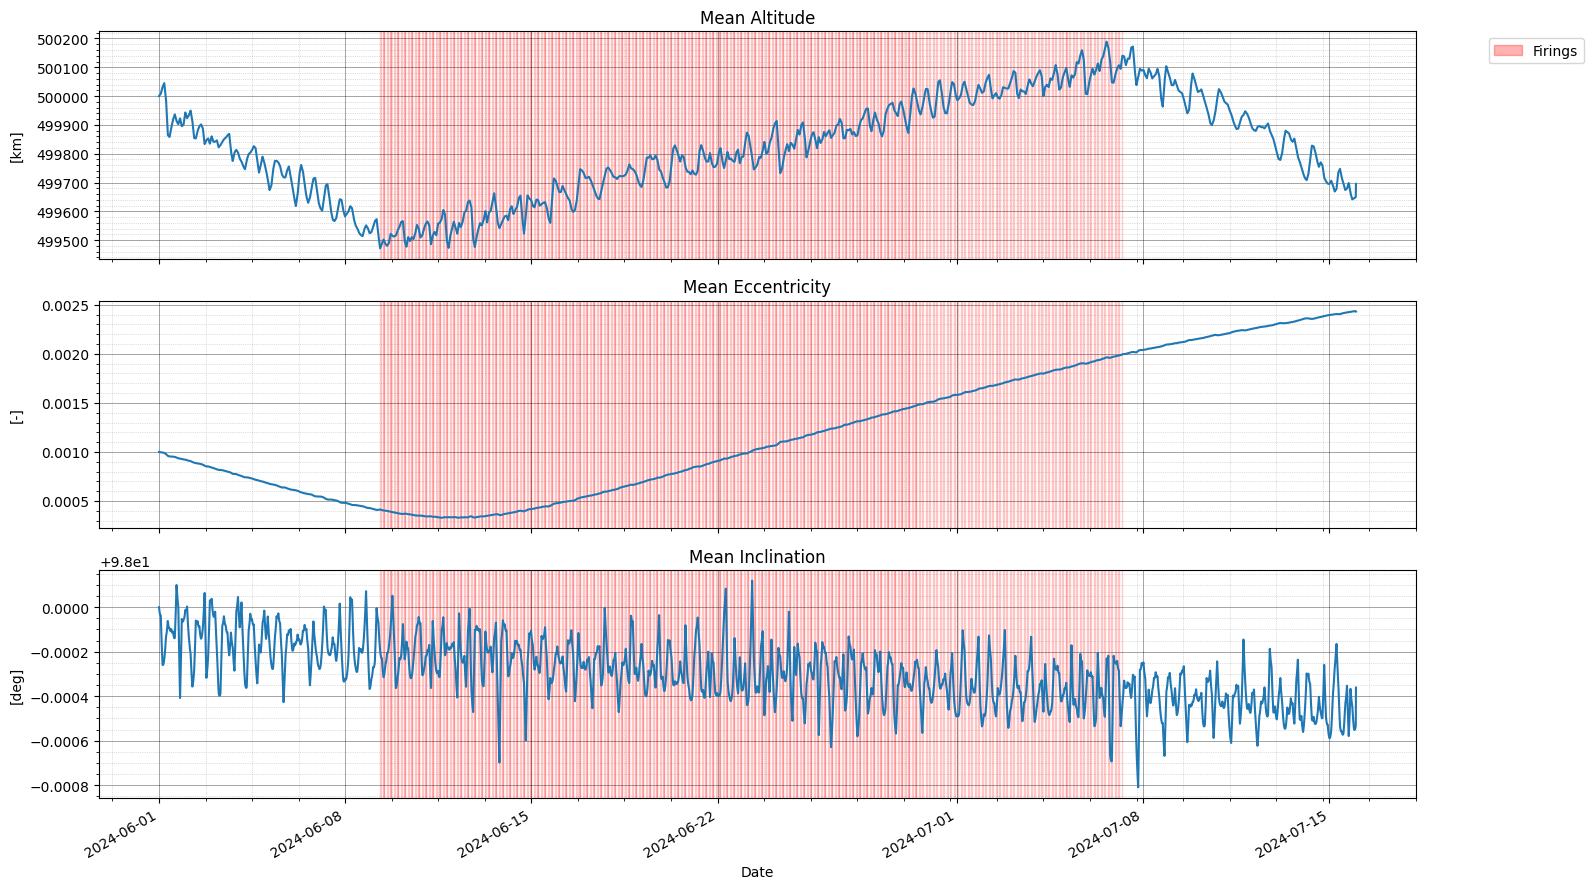

In [8]:
keplerian_data = res.export_keplerian_ephemerides_data()

df = pd.DataFrame(keplerian_data)

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(16, 9))

axs[0].plot(df['date'], df['MeanSma'] - EARTH_RADIUS)
axs[0].set_title("Mean Altitude")
axs[0].set_ylabel("[km]")

axs[1].plot(df['date'], df['MeanEcc'])
axs[1].set_title("Mean Eccentricity")
axs[1].set_ylabel("[-]")

axs[2].plot(df['date'], np.degrees(df['MeanInc']))
axs[2].set_title("Mean Inclination")
axs[2].set_ylabel("[deg]")

for ax in axs:
    add_grid(ax)
    draw_rectangles(ax, firing_start_dates, firing_end_dates)

axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[-1].set_xlabel("Date")

fig.autofmt_xdate()
fig.align_ylabels()
fig.tight_layout()
plt.show()

#### Quaternions

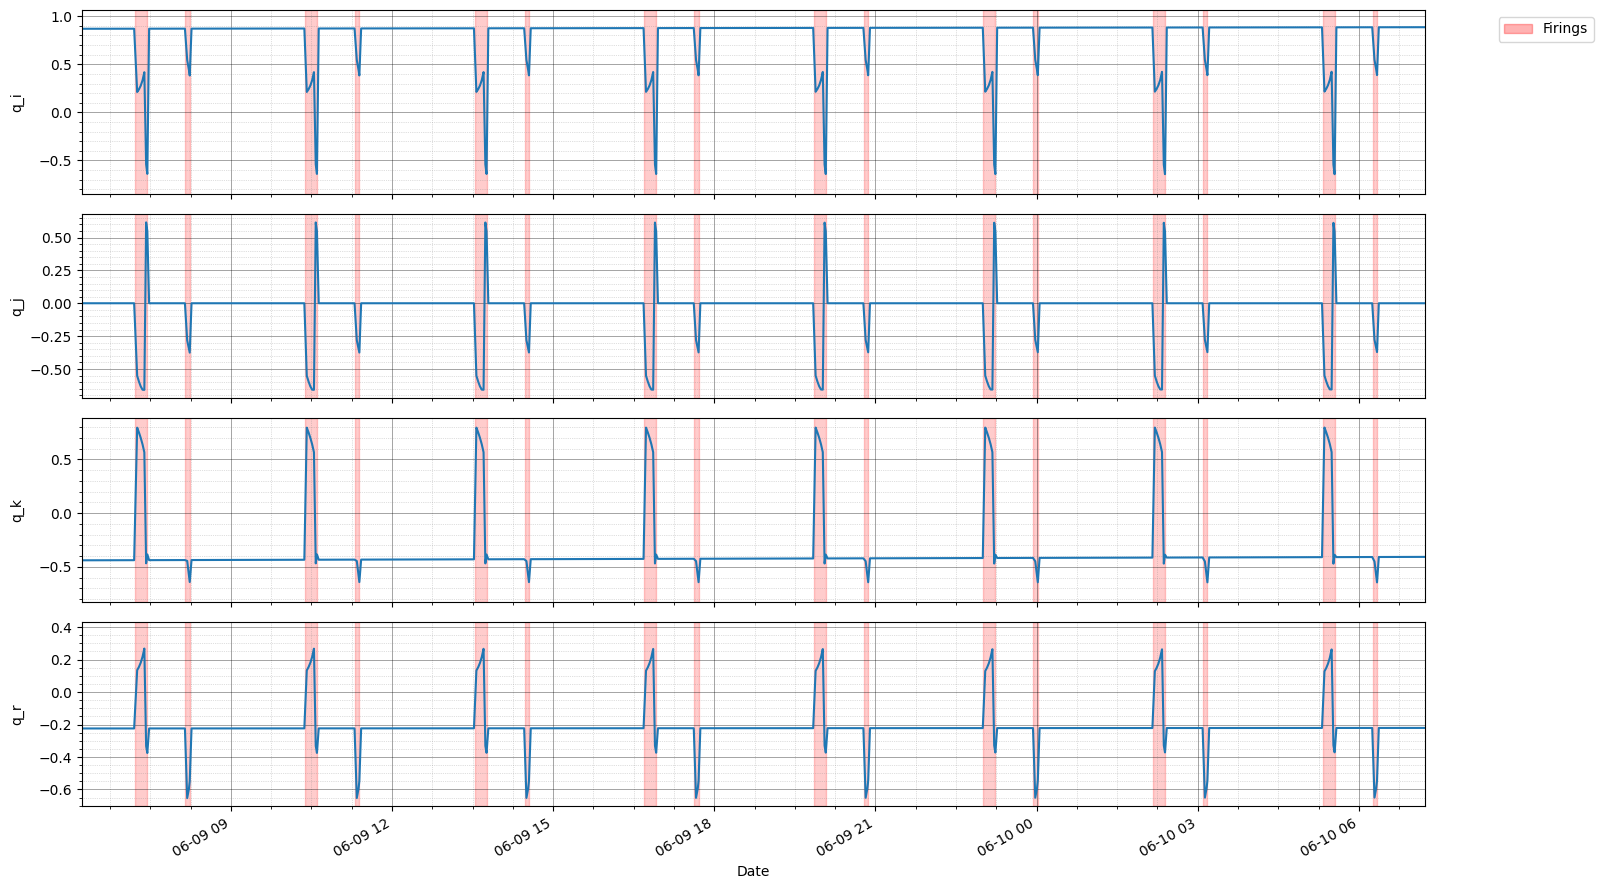

In [9]:
quaternions = roadmap.actions[0].quaternions
dates = [q.date for q in quaternions]

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(16, 9))

q_i, q_j, q_k, q_r = [], [], [], []
for q in quaternions:
    q_i.append(q.i)
    q_j.append(q.j)
    q_k.append(q.k)
    q_r.append(q.real)

axs[0].plot(dates, q_i)
axs[0].set_ylabel("q_i")
axs[1].plot(dates, q_j)
axs[1].set_ylabel("q_j")
axs[2].plot(dates, q_k)
axs[2].set_ylabel("q_k")
axs[3].plot(dates, q_r)
axs[3].set_ylabel("q_r")

for ax in axs:
    add_grid(ax)
    draw_rectangles(ax, firing_start_dates, firing_end_dates)
    ax.set_xlim([firing_start_dates[0] - timedelta(hours=1), firing_start_dates[0] + timedelta(days=1)])

axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[-1].set_xlabel("Date")

fig.autofmt_xdate()
fig.align_ylabels()
fig.tight_layout()
plt.show()


#### System data

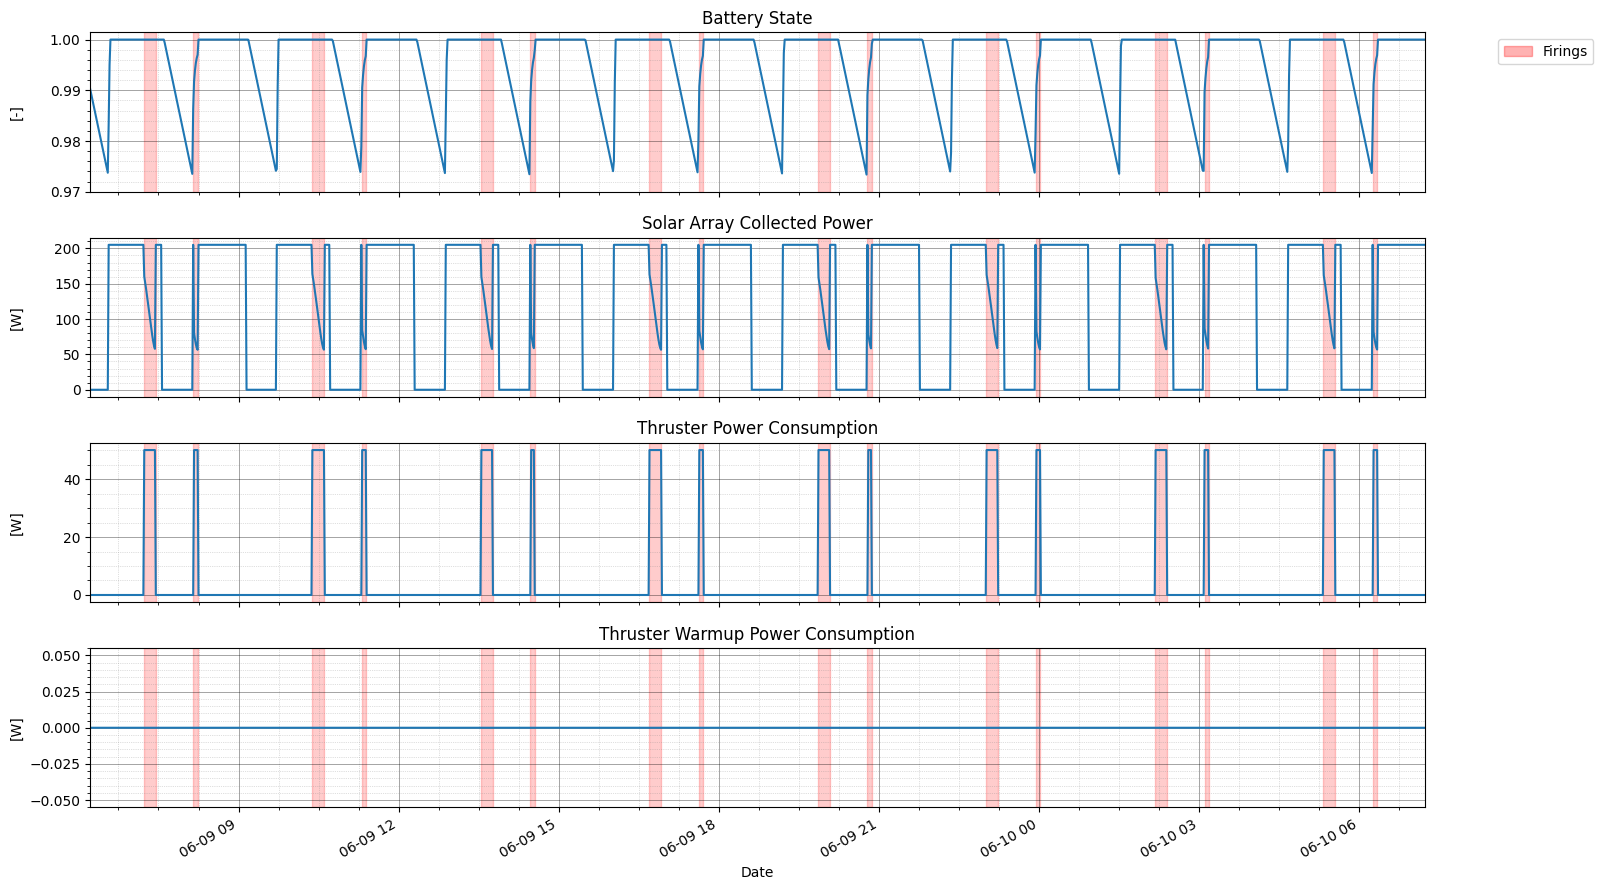

In [10]:
system_data = res.export_power_system_ephemerides_data()

if system_data is not None:
    df = pd.DataFrame(system_data)

    # Plot the battery charge
    fig, axs = plt.subplots(4, 1, sharex=True, figsize=(16, 9))

    axs[0].plot(df['date'], df['battery_charge'])
    axs[0].set_title("Battery State")
    axs[0].set_ylabel("[-]")

    axs[1].plot(df['date'], df['solar_array_collected_power'])
    axs[1].set_title("Solar Array Collected Power")
    axs[1].set_ylabel("[W]")

    axs[2].plot(df['date'], df['thruster_power_consumption'])
    axs[2].set_title("Thruster Power Consumption")
    axs[2].set_ylabel("[W]")

    axs[3].plot(df['date'], df['thruster_warm_up_power_consumption'])
    axs[3].set_title("Thruster Warmup Power Consumption")
    axs[3].set_ylabel("[W]")

    for a in axs:
        add_grid(a)
        draw_rectangles(a, firing_start_dates, firing_end_dates)
        a.set_xlim([firing_start_dates[0] - timedelta(hours=1), firing_start_dates[0] + timedelta(days=1)])

    axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[-1].set_xlabel("Date")

    fig.autofmt_xdate()
    fig.align_ylabels()
    fig.tight_layout()

    plt.show()

## Report

In [11]:
report = res.report

print("Station Keeping Report")
print("Total delta-v", report.total_delta_v, " m/s")
print("Thrust duration", report.thrust_duration, " s")
print("Number of burns", report.number_of_burns)
print("Simulation duration", report.simulation_duration/86400, " days")
print("Total consumption", report.total_consumption, " kg")

Station Keeping Report
Total delta-v 1.1233557210363734  m/s
Thrust duration 544.4846516784731  s
Number of burns 425
Simulation duration 45.0  days
Total consumption 0.004719368529790521  kg
